# Binary Logistic Regression From Sratch!
### Cara Mulrooney & Maya Cranor

Binary logistic regression is a supervised learning technique that employs mathematics to find the relationship between a dependent binary output variable, typically coded as 0 or 1, and another one or more nominal, ordinal, interval or ratio-level independent input variables. The method then uses these relationships to estimate the probability that the binary variable belongs to a specific class given the values of the independent variables. The probability threshold is often set to 0.5, meaning that if the predicted probability of an observation belonging to class 1 is equal to or greater than 0.5, it is classified as belonging to that class; otherwise, it is classified as belonging to class 0. 

### Logistic Regression Example

Logistic regression models the probability that an input (x) belongs to the default class, such as y=1. This idea is represented in Equation (0).

$$
P(X) = P(Y=1|X) \tag{4}
$$

For example, we could represent a person’s sex as male or female from their height using logistic regression. Logistic regression may be suitable in this situation, given a nominal, ordinal, interval or ratio-level input, binary output, and that there is, hypothetically, a relationship between height and the odds of a person’s sex. The outcome variable, the person’s sex, is binary, and the input variable, the person’s height, is numerical. In this scenario, the default class could be male (chosen arbitrarily), and the model could be written as the likelihood of male given a person’s height. Here, we can use Equation (4), where Y is the predicted sex, and X is the person’s height.
Since the logistic regression technique estimates the likelihood of an input belonging to a particular class converted into binary values (0 or 1) using the logistic regression formula shown in Equation (2), making predictions involves simply plugging in numbers and finding the result.
Continuing with the same example above, let’s model whether person A is male or female based on their height, given that they are 150cm tall. Our maximum-likelihood function has provided the coefficients of $\beta_0$= -100 and $\beta_1$= 0.6. Using the logistic regression equation, we can simplify this calculation found in Equation (5), showing the near zero probability that person A is male. In practice we can determine that the associated class is 0 (female) if the probability of someone as male is less than 0.5, and 1 otherwise.

$$
P = {1 \over (1+e^{-(\beta_{0}+\beta_{1}*x)})} = {1 \over (1+e^{-(-100+0.6*150)})} = 0.000045 \tag{5}
$$


Let's start by creating a random dataset to later classify using our logistic regression model.

In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit, logit
from sklearn.linear_model import LogisticRegression
import matplotlib.patches as mpatches
import time
import pandas as pd 
import seaborn as sns
from  sklearn.model_selection import train_test_split

## Creating a Random Simulated Test Data Set

In [2]:
# Create starting input for numpy's pseudo-random generator
np.random.seed(12)
num_observations = 4000

# Generates two sets of random observations (x1 and x2) from multivariate normal distributions with specific means and covariance matrices
x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

# Stack x1 and x2 vertically to make a single array
simulated_separableish_features = np.vstack((x1, x2)).astype(np.float32)
# Create a list of labels (0 or 1) for simulated_separable_features
simulated_labels = np.hstack((np.zeros(num_observations), np.ones(num_observations)))

Text(0.5, 1.0, 'Randomly Generated Data')

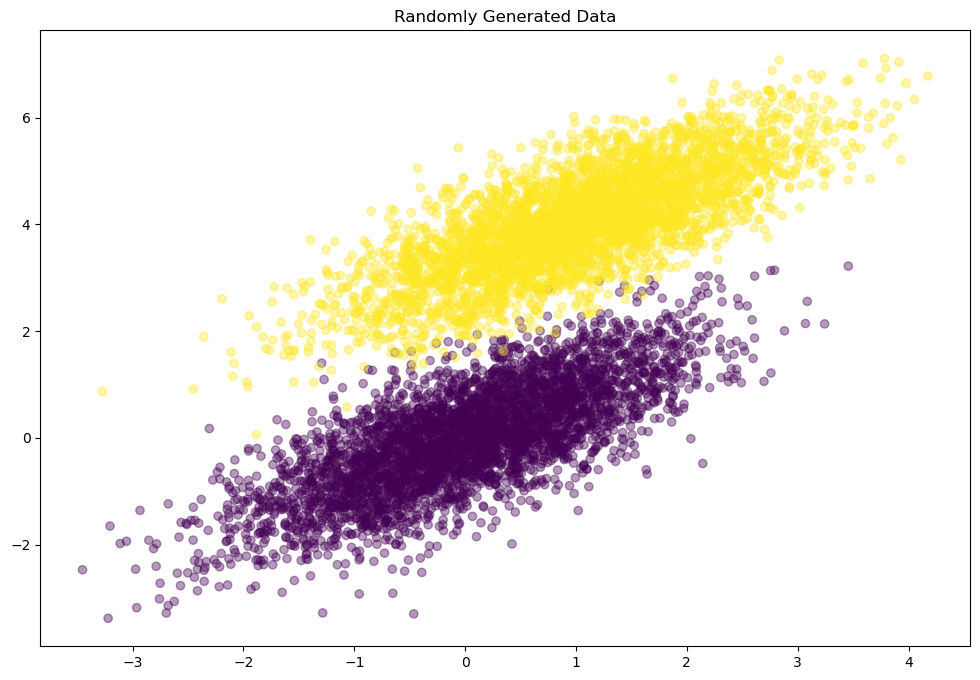

In [3]:
# Plot the random data set
plt.figure(figsize=(12,8))
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c = simulated_labels, alpha = .4)
plt.title("Randomly Generated Data")

### How Binary Logistic Regression Works
Binary logistic regression relies on the logistic function, also known as the sigmoid function, an S-shaped curve that takes a real-valued number as an input and maps it to an output value between 0 and 1, exclusive. The logistic function is shown in Equation (1).
$$
y = {1 \over (1+e^{-x})} \tag{1}
$$

The logistic regression algorithm employs the logistic function equation to predict binary output values by combining input values linearly using weights. The logistic regression equation, as expressed in Equation (2), encapsulates this process. 

$$
P = {1 \over (1+e^{-(\beta_{0}+\beta_{1}*x)})} \tag{2}
$$

where $P$ is the predicted output, $\beta_{0}$ is the intercept tem, and $\beta_{1}$ is the coefficient for the input value, $x$. 

Each input value has an associated  coefficient. These coefficients are constant values estimated from training data using maximum-likelihood estimation (MLE). The log-likelihood function, depicted in Equation (3), optimizes these coefficients to minimize the error in the predicted class probabilities and the actual class labels in the training data. 

$$
l(\beta) = \Sigma^{n}_{i=1} y_i \beta x_i - log(1+e^{\beta x_i}) \tag{3}
$$

This optimization process involves the formulation of a loss function, which quantifies how well the model is performing by measuring the difference between its predictions and the actual outcomes. Techniques like gradient descent are commonly applied to iteratively adjust the coefficients in the direction that maximizes the log-likelihood, the MLE loss function, enhancing the model’s predictive accuracy. 
In gradient descent, the gradient of the log-likelihood function with respect to the coefficients is computed, which indicates the direction in which the function is the steepest. The coefficients are then adjusted in the opposite direction of the gradient to move towards the maximum likelihood. The process is repeated iteratively until convergence, where the changes in the log-likelihood become small, indicating that the algorithm has found optimal coefficients. The learning rate in gradient descent controls the size of the steps taken during each iteration, balancing convergence speed and stability.


### Logistic Regression Implementation

In [4]:
def sigmoid(scores: np.ndarray) -> np.ndarray:
    """
    Calculate the sigmoid function for a given set of scores.

    Parameters:
    - scores (numpy.ndarray): An array of real-valued scores.

    Returns:
    - numpy.ndarray: An array of values between 0 and 1, representing the sigmoid
                    transformation of the input scores.
    """
    return 1 / (1 + np.exp(-scores))

In [5]:
def log_likelihood(features: np.ndarray, target: np.ndarray, weights: np.ndarray) -> float:
    """
    Calculate the log-likelihood of logistic regression.

    Parameters:
    - features (numpy.ndarray): Input features, represented as a 2D array.
    - target (numpy.ndarray): Binary target variable, represented as a 1D array.
    - weights (numpy.ndarray): Coefficients (weights) associated with each feature.

    Returns:
    - float: Log-likelihood value for the given logistic regression model.
    """
    # Calculate the dot product of features and weights to get the scores
    scores = np.dot(features, weights)
    
    # Calculate the log-likelihood using the logistic regression formula
    log_likelihood = np.sum(target * scores - np.log(1 + np.exp(scores)))
    
    return log_likelihood

In [6]:
def logistic_regression(features: np.ndarray, target: np.ndarray, num_steps: int, learning_rate: float, add_intercept=False)-> np.ndarray:
    """
    Perform logistic regression using gradient descent.

    Parameters:
    - features (np.ndarray): Input features, represented as a 2D array.
    - target (np.ndarray): Binary target variable, represented as a 1D array.
    - num_steps (int): Number of steps (iterations) for gradient descent.
    - learning_rate (float): Step size for each iteration of gradient descent.
    - add_intercept (bool, optional): Flag to indicate whether to add an intercept term. Default is False.

    Returns:
    - numpy.ndarray: Coefficients (weights) for the logistic regression model.
    """
    # Add intercept term to features if specified
    if add_intercept:
        intercept = np.ones((features.shape[0], 1))
        features = np.hstack((intercept, features))

    # Initialize weights to zeros
    weights = np.zeros(features.shape[1])

    # Perform gradient descent for the specified number of steps
    for step in range(num_steps):
        # Calculate scores and predictions using current weights
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights using gradient descent
        output_error_signal = target - predictions
        gradient = np.dot(features.T, output_error_signal)
        weights += learning_rate * gradient

        # Print log-likelihood every 10,000 steps for monitoring
        if step % 10000 == 0:
            print(log_likelihood(features, target, weights))

    return weights

In [7]:
start_time = time.time()
weights = logistic_regression(simulated_separableish_features, simulated_labels,
                               num_steps=300000, learning_rate=5e-5, add_intercept=True)
end_time = time.time()
scratch_time = end_time - start_time
print(f"Execution time: {scratch_time} seconds")

-3616.8070227515736
-109.02594680967276
-101.90354820003512
-99.69196343370092
-98.74000895437229
-98.26644938187675
-98.01085574806197
-97.86559198076156
-97.78008708131543
-97.72848832032848
-97.69677702810485
-97.67701955401182
-97.66458070840706
-97.65668615101313
-97.65164413739592
-97.64840802143414
-97.64632286526881
-97.64497514850507
-97.64410191357612
-97.643534994805
-97.64316635904129
-97.64292635115746
-97.6427699295051
-97.64266790016407
-97.64260130528704
-97.64255781538685
-97.6425294019952
-97.64251083212912
-97.64249869219239
-97.64249075398152
Execution time: 50.25571894645691 seconds


## Results

In [8]:
# Adding a column of ones to the simulated features to account for the intercept term
data_with_intercept = np.hstack((np.ones((simulated_separableish_features.shape[0], 1)),
                                 simulated_separableish_features))

# Calculating the final scores by taking the dot product of the data with intercept and the weights
final_scores = np.dot(data_with_intercept, weights)

# Applying the sigmoid function to the final scores and rounding the result to obtain predictions
prediction = np.round(sigmoid(final_scores))

print ('Accuracy from scratch: {0}'.format((prediction == simulated_labels).sum().astype(float) / len(prediction)))

Accuracy from scratch: 0.995375


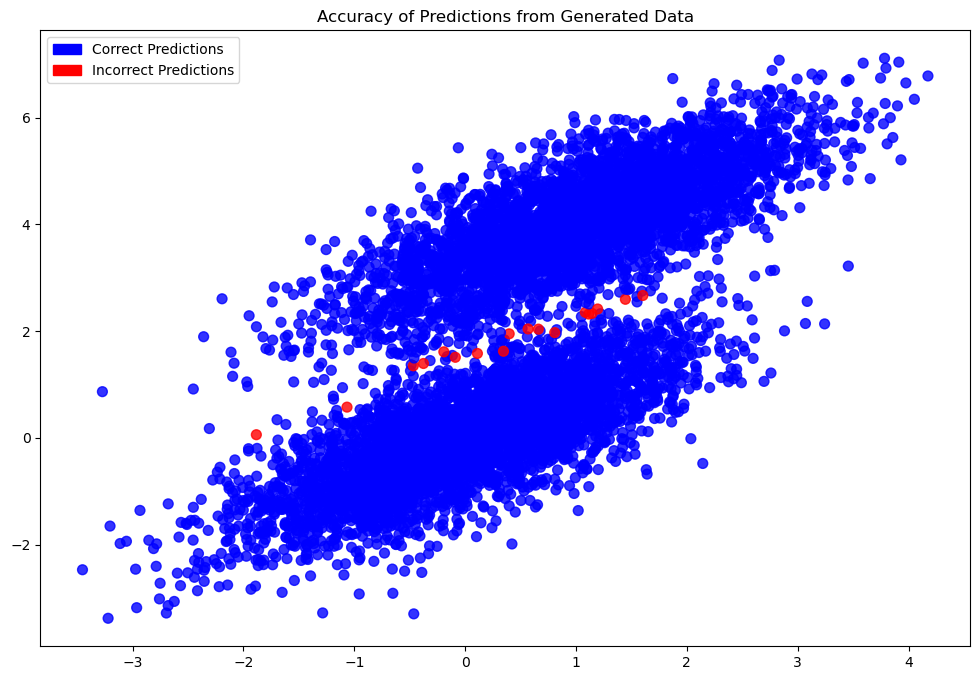

In [11]:
plt.figure(figsize=(12, 8))

# Scatter plot with blue dots for correct predictions and red dots for incorrect predictions
plt.scatter(simulated_separableish_features[:, 0], simulated_separableish_features[:, 1],
            c=np.where(prediction == simulated_labels - 1, 'red', 'blue'), alpha=.8, s=50)

plt.title("Accuracy of Predictions from Generated Data")
# Create a legend
blue_patch = mpatches.Patch(color='blue', label='Correct Predictions')
red_patch = mpatches.Patch(color='red', label='Incorrect Predictions')
plt.legend(handles=[blue_patch, red_patch])
plt.show()

## Comparison with Sk-Learn’s LogisticRegression

In [10]:
start_time = time.time()

# Creating Sk-Learn's Logistic Regression classifier without L2 regularization
clf = LogisticRegression(fit_intercept=True, C=1e15)

# Running simulated data on the classifier
clf.fit(simulated_separableish_features, simulated_labels)

end_time = time.time()
sklearn_time = end_time - start_time

# Weights
print ("Weights from scratch algorithm:     ",weights)
print ("Weights from Sk-Learn’s algorithm:  ",clf.intercept_, clf.coef_)

# Execution Time
print(f"Scratch's execution time: {scratch_time} seconds")
print(f"SK-learn's execution time: {sklearn_time} seconds")

# Accuracy
print ('Accuracy from scratch: {0}'.format((prediction == simulated_labels).sum().astype(float) / len(prediction)))
print ('Accuracy from sk-learn: {0}'.format(clf.score(simulated_separableish_features, simulated_labels)))

Weights from scratch algorithm:      [-15.31315695  -5.44842354   8.79722402]
Weights from Sk-Learn’s algorithm:   [-15.3188385] [[-5.45037816  8.80039247]]
Scratch's execution time: 50.25571894645691 seconds
SK-learn's execution time: 0.014606952667236328 seconds
Accuracy from scratch: 0.995375
Accuracy from sk-learn: 0.995375


The weights of both algorithm are nearly equal. If the algorithm built from scratch was run for longer and with smaller steps it would eventually match exactly. It happens to be close enough that both algorithms get the exact same results and accuracy. However the algorithm built from scratch takes a lot longer to get the same results since the Sk-learn's algorithm has a ton of extra optimizations.

### Annotated Sources

https://machinelearningmastery.com/logistic-regression-for-machine-learning/
* This article had a very clear, step-by-step walkthrough and explanation on how logistic regression works, complete with several examples.

https://aws.amazon.com/what-is/logistic-regression/#:~:text=Logistic%20regression%20is%20a%20data,outcomes%2C%20like%20yes%20or%20no.
* This article had very clear definitions and comparisons between logistic regression and other machine learning techniques, such as deep learning and linear regression.

https://youtu.be/yIYKR4sgzI8?si=o6w4EpFzdKjkmNov
* This video explained logistic regression in a very simple way using visuals and examples that were very easy to understand.

https://towardsdatascience.com/logistic-regression-detailed-overview-46c4da4303bc
* This article had a very good visualization of how the algorithm works as well as a thorough explanation of the different types of logistic regression and where they might be used.

https://arunaddagatla.medium.com/maximum-likelihood-estimation-in-logistic-regression-f86ff1627b67
* This article had a very clear explanation of maximum likelihood estimation used in logistic regression

https://beckernick.github.io/logistic-regression-from-scratch/

https://youtu.be/yIYKR4sgzI8?si=o6w4EpFzdKjkmNov
